# Analysis

In [1]:
import pandas as pd

## 1 process

In [2]:
raw = pd.read_excel('./data//car_sale_2015_16.xlsx')
raw.dropna(inplace=True)
raw.reset_index(drop=True, inplace=True)

In [3]:
raw.shape

(473, 8)

In [4]:
def get_basic_weight(x):
    data = str(x).strip('[]').replace('\'', '').split(',')
    data = max(data,key=data.count)
    data = data.lstrip('●').lstrip(' ')
    return None if ((data=='-') or (data=='nan')) else int(data)

def get_basic_brake(x):
    data = str(x).strip('[]').replace('\'', '').split(',')
    data = max(data,key=data.count)
    data = data.lstrip('●').lstrip(' ')
    if '通风盘式' in data:
        return 'ventiled'
    elif '盘式' in data:
        return 'disc'
    elif '鼓式' in data:
        return 'drum'
    else:
        return None

car_map = {
    'SUV': 'SUV', 
    'MPV': 'MPV',
    '微型车': 'microcar',
    '小型车': 'small car',
    '紧凑型车': 'compact car',
    '中型车': 'mid-size car',
    '中大型车': 'large car',
    '大型车': 'luxury car',
    '跑车': 'sports car',
    '不限': None
}

def get_class(x):
    data = str(x).strip('[]').replace('\'', '').split(',')
    data = max(data,key=data.count)
    data = data.lstrip('●').lstrip(' ')
    for k,v in car_map.items():
        if k in data:
            return v

fuel_type_map = {
    '增程': 'REEV',
    '新能源': 'NEV',
    '油电混合': 'HEV',
    '燃油车': 'ICEV', 
    '纯电动': 'BEV'
}

def get_fuel_type(x):
    data = str(x).strip('[]').replace('\'', '').split(',')
    data = max(data,key=data.count)
    data = data.lstrip('●').lstrip(' ')
    if '汽油' in data:
        return 'ICEV'
    elif '纯电动' in data:
        return 'BEV'
    elif '混' in data:
        return 'HEV'
    else:
        return 'others'

In [5]:
sales = raw.copy()
sales['weight'] = sales['weight'].map(get_basic_weight)
sales['frontB'] = sales['frontB'].map(get_basic_brake)
sales['rearB'] = sales['rearB'].map(get_basic_brake)
sales['fuel'] = sales['fuel'].map(get_fuel_type)
sales['class'] = sales['class'].map(get_class)
sales.head()

,model,sales,class,fuel,weight,frontB,rearB,link
0,RAV4荣放,2944764,SUV,ICEV,1595.0,ventiled,disc,https://www.16888.com/57506/
1,金刚,1938660,small car,ICEV,1103.0,ventiled,drum,https://www.16888.com/57606/
2,奥丁,1651151,SUV,others,1695.0,disc,drum,https://www.16888.com/57472/
3,五菱宏光,1223033,MPV,ICEV,NaN,disc,drum,https://www.16888.com/125978/
4,哈弗H6,873417,SUV,ICEV,NaN,ventiled,disc,https://www.16888.com/117870/


In [6]:
num = sales[['fuel', 'sales']].groupby(by=['fuel']).sum()
num

,sales
fuel,
BEV,120304
HEV,1457424
ICEV,47178770
others,1755584


## 2 Analysis

In [28]:
ps_level_list = ['small car', 'compact car', 'mid-size car', 'large car']
ps_car = sales[(sales['class'].isin(ps_level_list)) & (sales['fuel'] == 'ICEV')].copy()

In [80]:
ps_car.shape

(231, 8)

### fuel type

In [29]:
num_fuel = ps_car[['fuel', 'sales']].groupby(by=['fuel']).sum()
num_fuel['prop'] = num_fuel['sales'] / num_fuel['sales'].sum()
num_fuel

,sales,prop
fuel,,
ICEV,25186797,1.0


### weight

In [30]:
import matplotlib.pyplot as plt
# font
plt.rcParams['font.sans-serif'] = ['Arial']
LABEL_FONT = {
    "fontsize": 12,
    "weight": "bold",
}    
plt.rcParams['figure.dpi'] = 500

In [31]:
num_weight = []  # weighted numbers of weight
ps_car_weight = ps_car[ps_car['weight'].notna()].copy()

for index, row in ps_car_weight.iterrows():
    weights = [row['weight']] * int(row['sales'] / 100)
    num_weight += weights

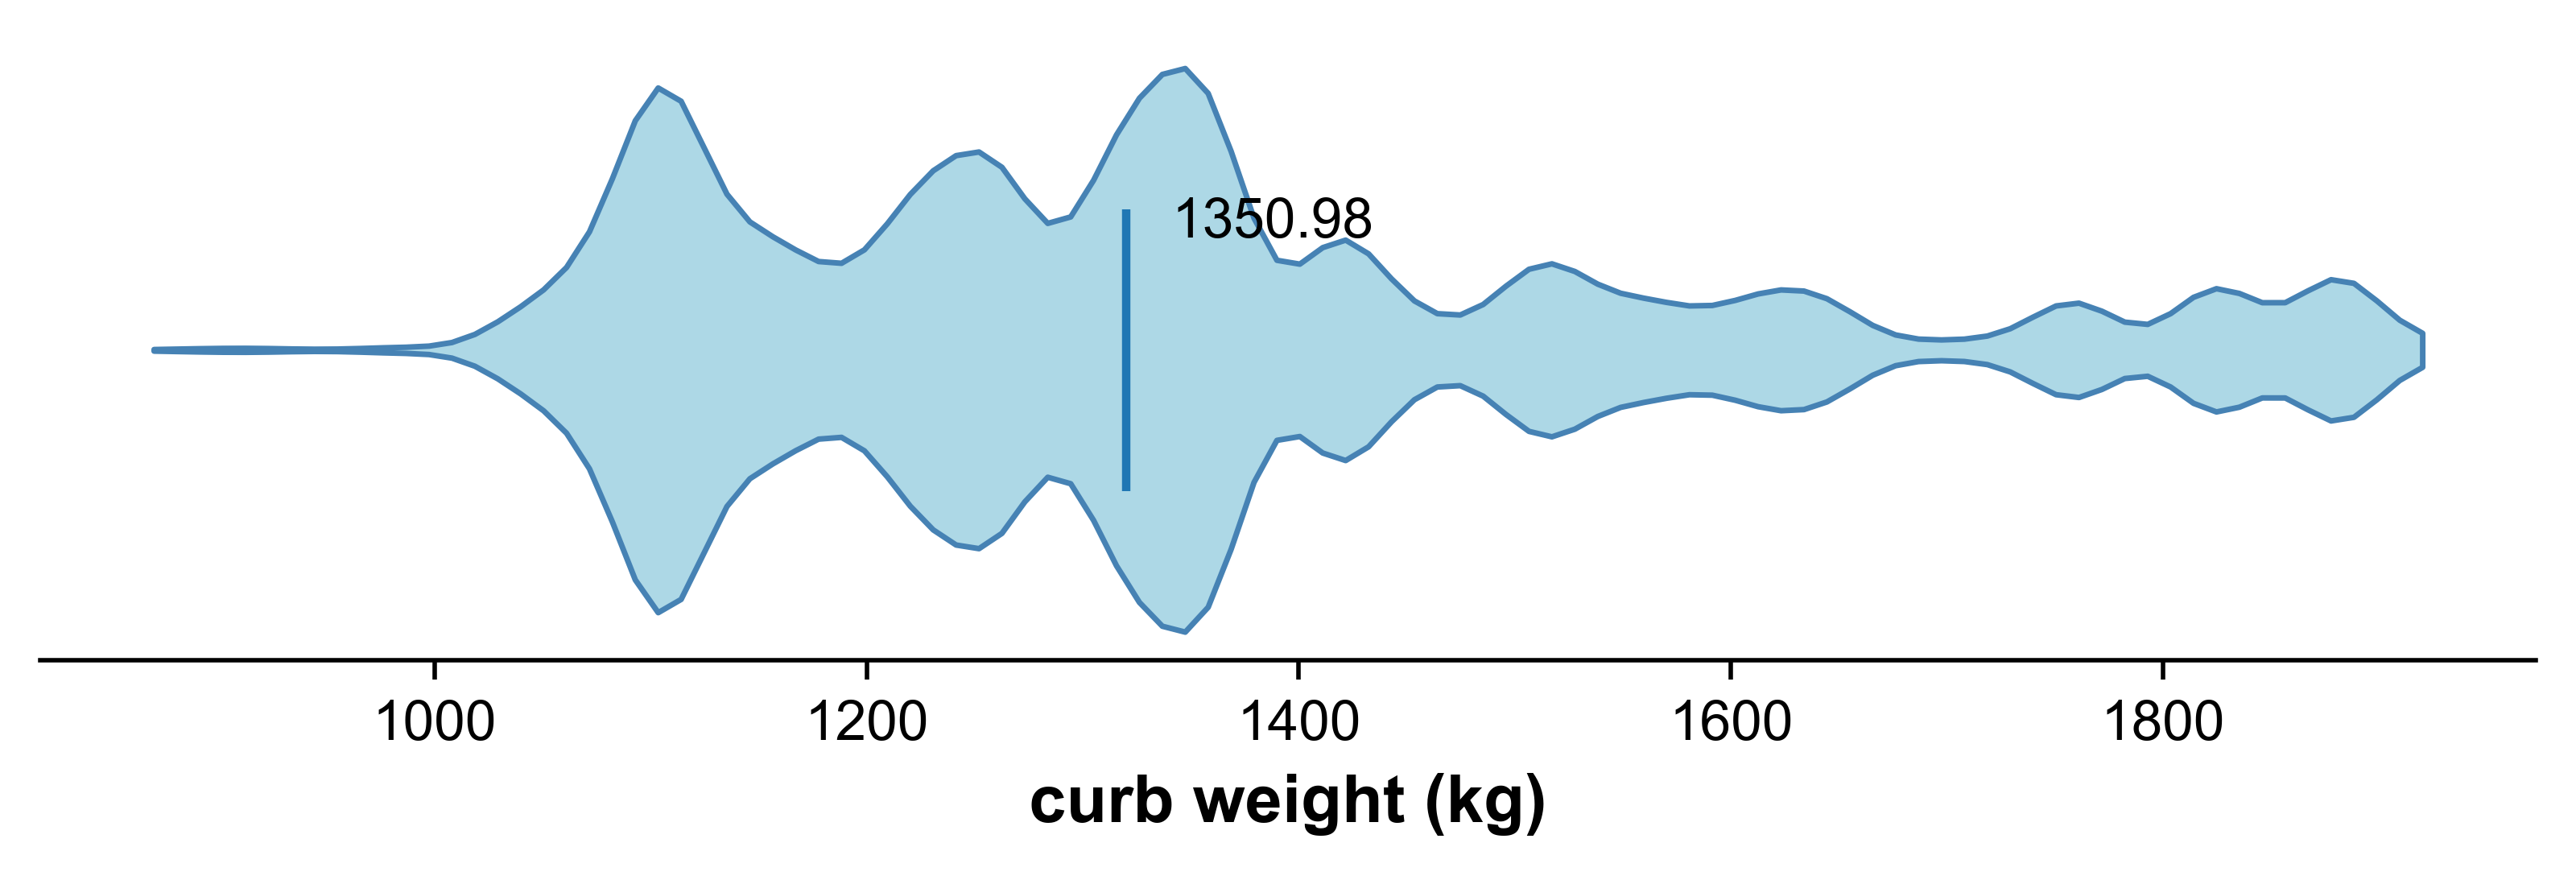

In [79]:
fig, ax = plt.subplots(1,1, figsize=(8,2))

parts = ax.violinplot(
    [num_weight],
    vert=False,
    showmeans=False,
    showmedians=True,
    showextrema=False,
)

for pc in parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_edgecolor('steelblue')
    pc.set_alpha(1)

mean = sum(num_weight) / len(num_weight)
ax.text(mean-10, 1.1, "%.2f" % mean, ha='left')

ax.set_yticks([])
ax.set_xlabel('curb weight (kg)', fontdict=LABEL_FONT)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.show()

### Brake

In [47]:
ps_car['frontB'] = ps_car['frontB'].map({'ventiled': 'disc', 'disc': 'disc', 'drum':'drum'})
front_brake_num = ps_car[['sales', 'frontB']].groupby(by=['frontB']).sum()
front_brake_num.loc['drum', 'sales'] = 0
front_brake_num['prop'] = front_brake_num['sales'] / front_brake_num['sales'].sum()
front_brake_num

,sales,prop
frontB,,
disc,25186797.0,1.0
drum,0.0,0.0


In [48]:
ps_car['rearB'] = ps_car['rearB'].map({'ventiled': 'disc', 'disc': 'disc', 'drum':'drum'})
rear_brake_num = ps_car[['sales', 'rearB']].groupby(by=['rearB']).sum()
rear_brake_num['prop'] = rear_brake_num['sales'] / rear_brake_num['sales'].sum()
rear_brake_num
rear_brake_num

,sales,prop
rearB,,
disc,19575355,0.777207
drum,5611442,0.222793


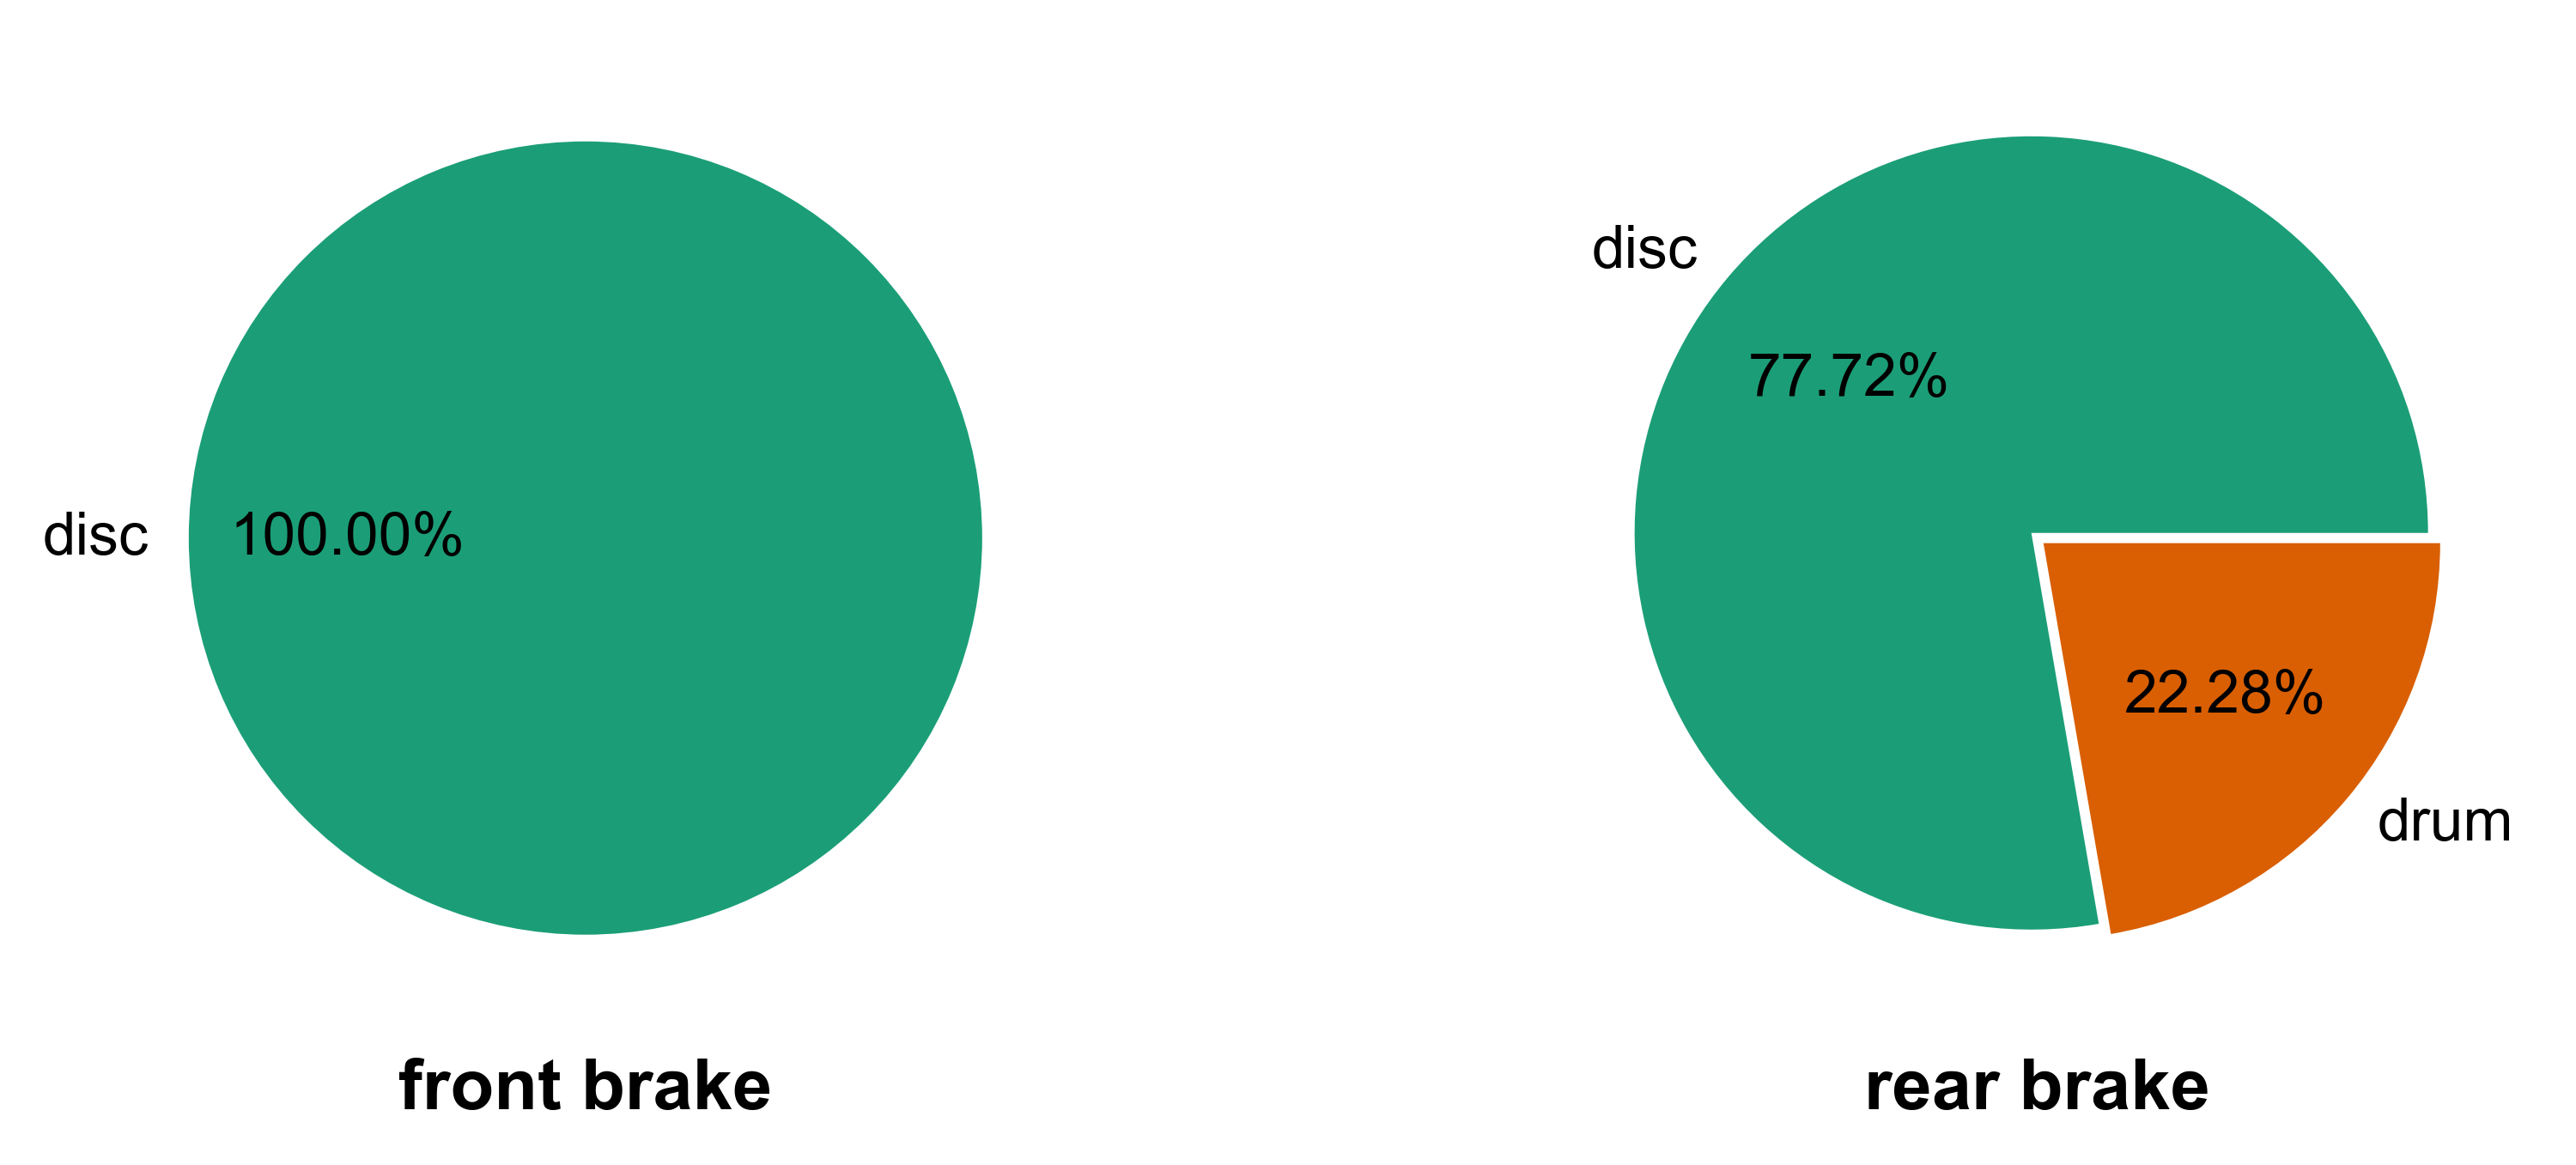

In [70]:
fig, ax = plt.subplots(1,2, figsize=(8,3))
# fig.subplots_adjust(wspace=0.2)

front = front_brake_num['prop']
rear = rear_brake_num['prop']

ax[0].pie(
    [1],
    labels = ['disc'],
    autopct='%.2f%%',
    colors = plt.get_cmap('Dark2')([0])
)
ax[0].set_xlabel('front brake', fontdict=LABEL_FONT)

ax[1].pie(
    rear.values,
    explode = [0.02, 0.02],
    # explode = [0.01, 0.03, 0.01, 0.01],
    labels = front.index,
    autopct='%.2f%%',
    colors = plt.get_cmap('Dark2')(range(rear.shape[0]))
)
ax[1].set_xlabel('rear brake', fontdict=LABEL_FONT)

plt.show()